In [1]:
import numpy as np
import pandas as pd
import datetime
import utils
import models
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
worksheet = utils.get_master_sheet()
df = pd.DataFrame(worksheet.get_all_records())
df.head()

,timestamp,game_date,game_time,name,team,position,opponent,stat,line,hit_percentage,margin,action,actual_stat,outcome,true_action
0,11/19/2023 17:02:49,2023-11-19,5:02:20 PM,Jarrett Allen,CLE,C,DEN,Points,14.5,50.34,0.34,OVER,15.0,WIN,OVER
1,11/19/2023 17:27:06,2023-11-19,7:00:00 PM,Jaylen Brown,BOS,G-F,MEM,Free Throws Made,3.5,50.34,0.34,OVER,1.0,LOSE,UNDER
2,11/19/2023 17:02:49,2023-11-19,8:10:00 PM,Shaedon Sharpe,POR,G,OKC,Points,19.5,50.22,0.22,OVER,7.0,LOSE,UNDER
3,11/19/2023 17:27:06,2023-11-19,7:10:00 PM,Devin Booker,PHX,G,UTA,Assists,8.0,50.19,0.19,OVER,8.0,PUSH,PUSH
4,11/19/2023 17:27:06,2023-11-19,7:10:00 PM,Devin Booker,PHX,G,UTA,3-PT Attempted,6.5,50.17,0.17,OVER,7.0,WIN,OVER


In [3]:
DATA_OUTPUT_DIR = './output'

datarows = []
X = []
Y = []

predictors = [
    'past_games_over_line',
    'homeaway_over_line',
    'vsopponent_over_line',
    'rest1',
    'rest2',
    'rest3',
    'opp_give_up_ppg',
    'opp_give_up_rpg',
    'opp_give_up_apg',
    'opp_give_up_tovpg',
]

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        if row['true_action'] == 'PUSH':
            continue
        if pd.isna(row['true_action']) or row['true_action'] == '':
            continue
        player_name = row['name']
        stat = utils.get_stat_name(row['stat'])
        pp_line = float(row['line'])
        opponent = row['opponent']
        game_date=datetime.datetime.strptime(row['game_date'], '%Y-%m-%d')

        nba_engine = models.Predictor(player_name, stat, opponent, pp_line, game_date)
        info = {}
        for pn in predictors:
            info[pn] = nba_engine.request_predictor(pn)
        info.update(row.to_dict())
        datarows.append(info)
        X.append([info[pn] for pn in predictors])
        Y.append(1 if row['true_action'] == 'OVER' else 0)
        
        if i > 0 and i%100==0:
            pd.DataFrame(datarows).to_csv(f'{DATA_OUTPUT_DIR}/datarows.csv', index=False)
            np.save(f'{DATA_OUTPUT_DIR}/X.npy', np.array(X))
            np.save(f'{DATA_OUTPUT_DIR}/Y.npy', np.array(Y))
        
    except Exception as e:
        print(f'Error {i}: {e}')

  0%|          | 0/4969 [00:00<?, ?it/s]

Error 355: HTTPSConnectionPool(host='stats.nba.com', port=443): Max retries exceeded with url: /stats/commonplayerinfo?LeagueID=&PlayerID=1629673 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x284a3f5e0>, 'Connection to stats.nba.com timed out. (connect timeout=30)'))


In [4]:
def load_data(output_dir):
    X = np.load(f'./{output_dir}/X.npy')
    Y = np.load(f'./{output_dir}/Y.npy')
    good = ~np.isnan(X).any(axis=1)
    X = X[good]
    Y = Y[good]
    good = np.isfinite(X).all(axis=1)
    X = X[good]
    Y = Y[good]
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)
    return X_standardized, Y

def plot_data(output_dir):
    X, Y = load_data(output_dir)
    pca = PCA(n_components=2)
    Xt = pca.fit_transform(X)
    plt.scatter(Xt[Y==1, 0], Xt[Y==1, 1], c='green', label='over', alpha=0.25)
    plt.scatter(Xt[Y==0, 0], Xt[Y==0, 1], c='red', label='under', alpha=0.25)
    plt.legend()
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    print(np.where(Xt[:, 0] > 8))
    plt.show()

(3869, 10)
(array([], dtype=int64),)


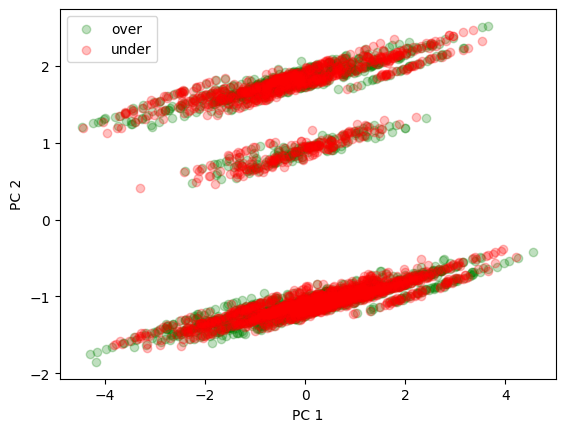

In [6]:
X, Y = load_data(DATA_OUTPUT_DIR)
print(X.shape)
plot_data(DATA_OUTPUT_DIR)

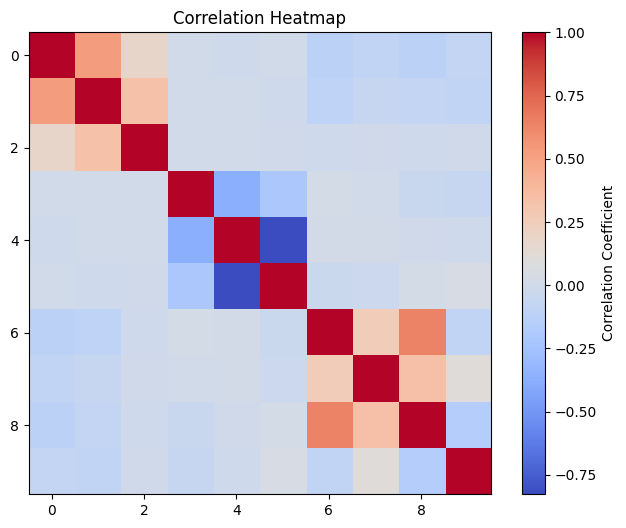

In [7]:
X, Y = load_data(DATA_OUTPUT_DIR)
corr_matrix = np.corrcoef(X, rowvar=False)
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Heatmap')
plt.show()

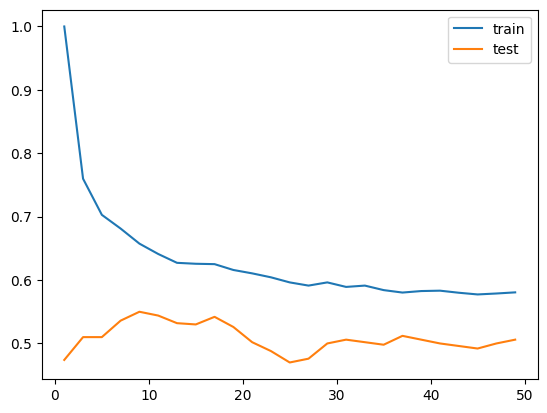

In [8]:
X, Y = load_data(DATA_OUTPUT_DIR)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
splitpt = 1000
X_train, X_test, Y_train, Y_test = X[:-500], X[-500:], Y[:-500], Y[-500:]
trainacc, testacc = [], []
for n in np.arange(1, 50, 2):
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train, Y_train)
    trainacc.append(neigh.score(X_train, Y_train))
    testacc.append(neigh.score(X_test, Y_test))
plt.plot(np.arange(1,50,2), trainacc, label='train')
plt.plot(np.arange(1,50,2), testacc, label='test')
plt.legend()
plt.show()

In [12]:
X, Y = load_data(DATA_OUTPUT_DIR)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=11)
neigh.fit(X_train, Y_train)
neigh.score(X_test, Y_test)

0.4909560723514212

In [17]:
X, Y = load_data(DATA_OUTPUT_DIR)
kf = KFold(n_splits=8)
avg_acc = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    X_train = X[train_index]
    y_train = Y[train_index]
    X_test = X[test_index]
    y_test = Y[test_index]
    # clf = AdaBoostClassifier(n_estimators=250).fit(X_train, y_train)
    # clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(12,)).fit(X_train, y_train)
    clf = KNeighborsClassifier(n_neighbors=11).fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    print(f'Accuracy on train set: {train_acc}')
    print(f'Accuracy on test set: {test_acc}')
    avg_acc.append(test_acc)
print('Average Test Accuracy', np.mean(np.array(avg_acc)))

Fold 0:
Accuracy on train set: 0.6425406203840472
Accuracy on test set: 0.5227272727272727
Fold 1:
Accuracy on train set: 0.6484490398818316
Accuracy on test set: 0.49793388429752067
Fold 2:
Accuracy on train set: 0.6451994091580502
Accuracy on test set: 0.5413223140495868
Fold 3:
Accuracy on train set: 0.6505169867060562
Accuracy on test set: 0.512396694214876
Fold 4:
Accuracy on train set: 0.651698670605613
Accuracy on test set: 0.4834710743801653
Fold 5:
Accuracy on train set: 0.6450088600118133
Accuracy on test set: 0.5383022774327122
Fold 6:
Accuracy on train set: 0.6429415239220319
Accuracy on test set: 0.515527950310559
Fold 7:
Accuracy on train set: 0.6414648552864737
Accuracy on test set: 0.5507246376811594
Average Test Accuracy 0.5203007631367316


In [18]:
X, Y = load_data(DATA_OUTPUT_DIR)
X_train, X_test, Y_train, Y_test = X[:-500], X[-500:], Y[:-500], Y[-500:]
clf = KNeighborsClassifier(n_neighbors=11).fit(X_train, Y_train)
# probs = clf.predict_proba(X_test)[:, 1]
# goodhp = np.logical_and(probs <= 0.6, probs >= 0.55)
print(clf.score(X_test, Y_test))
# print(clf.score(X_test[goodhp], Y_test[goodhp]))

0.544


In [19]:
from joblib import dump, load
dump(clf, 'knn.joblib')

['knn.joblib']